In [13]:
import openmc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#Link to the Paper the Parameters were obtained from:
#https://www.tandfonline.com/doi/full/10.1080/00295450.2021.1906474

In [14]:
#Parameters [cm]
monolith_pitch = 2.15
fuel_radius = 0.975
moderator_radius = 1
heat_pipe_radius = 1
height = 60

In [15]:
#Materials

#Fuel: Uranium Nitride (UN)
un = openmc.Material()
un.add_element('N', 1.0)
un.add_nuclide('U235', .1605, 'ao')
un.add_nuclide('U238', 1-.1605, 'ao')
un.set_density('g/cm3', 14.3)

#Moderator: Yttrium Hydride (YH2)
yh2 = openmc.Material()
yh2.add_element('Y', 1.0)
yh2.add_element('H', 2.0)
yh2.set_density('g/cm3', 4.3)

#Monolith: Stainless Steel 316 (various elements)
ss316 = openmc.Material()
ss316.add_element('Fe', 65.9, 'wo')
ss316.add_element('Cr', 17.0, 'wo')
ss316.add_element('Ni', 12.01, 'wo')
ss316.add_element('Mo', 2.0, 'wo')
ss316.add_element('Mn', 2.0, 'wo')
ss316.add_element('Si', 1.0, 'wo')
ss316.add_element('P', 0.04, 'wo')
ss316.add_element('S', 0.03, 'wo')
ss316.add_element('C', 0.02, 'wo') #Carbon is C0 when displayed
ss316.set_density('g/cm3', 7.9)

#Heat Pipe: Approxmated as Copper (Cu)
cu = openmc.Material()
cu.add_element('Cu', 1.0)
cu.set_density('g/cm3', 8.92)

In [5]:
#Cell Creation Functions
#Global Geometry
top = openmc.ZPlane(z0=height/2, boundary_type='vacuum')
bot = openmc.ZPlane(z0=-height/2, boundary_type='vacuum')
layer = -top & + bot

def zcylinder_maker(x,y,radius):
    return -openmc.ZCylinder(x0=x, y0=y, r=radius) & layer

#Box Maker
def box_maker(pitch):
    left = openmc.XPlane(-pitch, boundary_type='reflective')
    right = openmc.XPlane(pitch, boundary_type='reflective')
    front = openmc.YPlane(-pitch, boundary_type='reflective')
    back = openmc.YPlane(pitch, boundary_type='reflective')
    return +left & -right & +front & -back & layer

def void_box(pitch):
    return openmc.Cell(
        fill=None,
        region=box_maker(pitch),
    )

#Simple Cell Makers
def fuel_maker(x,y):
    return openmc.Cell(fill=un, region=zcylinder_maker(x,y,fuel_radius))

def mod_maker(x,y):
    return openmc.Cell(fill=yh2, region=zcylinder_maker(x,y,moderator_radius))

def heat_pipe_maker(x,y):
    return openmc.Cell(fill=cu, region=zcylinder_maker(x,y,heat_pipe_radius))

#Symmetric Four Quadrant Cell Makers
def four_quad_fuel(universe,x,y):
    universe.add_cell(fuel_maker(x,y))
    universe.add_cell(fuel_maker(x,-y))
    universe.add_cell(fuel_maker(-x,y))
    universe.add_cell(fuel_maker(-x,-y))

def four_quad_mod(universe,x,y):
    universe.add_cell(mod_maker(x,y))
    universe.add_cell(mod_maker(x,-y))
    universe.add_cell(mod_maker(-x,y))
    universe.add_cell(mod_maker(-x,-y))

def four_quad_heat_pipe(universe,x,y):
    universe.add_cell(heat_pipe_maker(x,y))
    universe.add_cell(heat_pipe_maker(x,-y))
    universe.add_cell(heat_pipe_maker(-x,y))
    universe.add_cell(heat_pipe_maker(-x,-y))

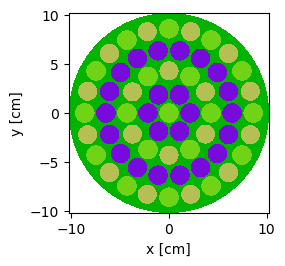

In [6]:
#Circular Heterogenous Lattice Universe
length_circ = 5
#length_circ is the (number of cells across the diameter - 1) /2
#Start at the central heat pipe and move out until the edge.
#^^Number of Cells crossed by this is length_circ^^
radius = (length_circ - .25) * monolith_pitch

circular_universe = openmc.Universe()
circular_universe.add_cell(heat_pipe_maker(0,0))

#Cylindrical Cells
layers = np.arange(1,length_circ)
for i in layers:
    #Creating Position Vectors
    theta = np.linspace(0, 2*np.pi, 1+(i*6))
    x_pos = np.cos(theta[:-1]) * (i*monolith_pitch)
    y_pos = np.sin(theta[:-1]) * (i*monolith_pitch)

    #Moderator Population
    if i%2 ==1:
        for j in range(len(x_pos)):
            circular_universe.add_cell(mod_maker(x_pos[j], y_pos[j]))
    elif i%2 == 0:
        for j in range(len(x_pos)):
            if j%2 == 0:
                circular_universe.add_cell(heat_pipe_maker(x_pos[j], y_pos[j]))
            elif j%2 == 1:
                circular_universe.add_cell(fuel_maker(x_pos[j], y_pos[j]))

#Monolith
boundary = zcylinder_maker(0,0,(layers[-1]+.75)*(monolith_pitch))
boundary.boundary_type = 'reflective'

monolith = openmc.Cell(
    fill=ss316,
    region=boundary,
)

circular_universe.add_cell(monolith)

#Edge
#circular_universe.add_cell(void_box(radius))

#Plotting
circular_universe.plot(color_by='material')
plt.show()

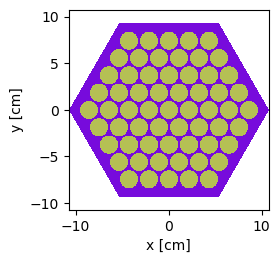

In [7]:
#Cheater Homogenous Hexagonal Lattice
layers = 4
#Layers is the number of layers out from the central heat pipe
#This is going to be one less than the number of cells an the outer edge

cheater_lattice_universe = openmc.Universe()

#Cylindrical Cells
heights = (3/4)**(.5) * np.linspace(0,1,layers+1) * (monolith_pitch*layers)
x_spacing = np.linspace(0,1,layers+1) * (monolith_pitch*layers)

for i in range(layers+1):
    pos = x_spacing - i*monolith_pitch/2
    for x in pos:
        four_quad_fuel(cheater_lattice_universe,x,heights[i])

#Monolith
hexagon = openmc.model.HexagonalPrism(
    edge_length=(layers+1)*monolith_pitch,
    orientation='x',
    origin=(0,0),
    boundary_type='reflective'
)

monolith = openmc.Cell(
    fill = ss316,
    region = -hexagon
)

cheater_lattice_universe.add_cell(monolith)

#Plotting
scope = 2.5 * layers * monolith_pitch
cheater_lattice_universe.plot(width=(scope,scope), color_by='material')
plt.show()

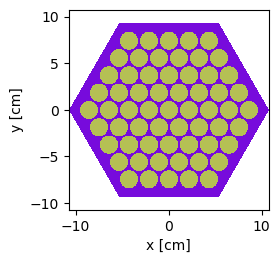

In [8]:
#Hexagonal Homogenous Lattice Universe
layers = 4
#Layers is the number of layers out from the central heat pipe
#This is going to be one less than the number of cells an the outer edge

lattice_universe = openmc.Universe()

#Cylindrical Cells

heights = (3/4)**(.5) * np.linspace(0,1,layers+1) * (monolith_pitch*layers)
x_spacing = np.linspace(0,1,layers+1) * (monolith_pitch*layers)

for i in range(layers+1):
    if i%2 != 0:
        pos = np.delete(x_spacing, np.arange(int(i/2)+1)) - i*monolith_pitch/2
    else:
        pos = np.delete(x_spacing, np.arange(int(i/2))) - i*monolith_pitch/2
    for j in range(len(pos)):
        four_quad_fuel(lattice_universe,pos[j],heights[i])


#Monolith
hexagon = openmc.model.HexagonalPrism(
    edge_length = (layers+1) * monolith_pitch,
    orientation = 'x',
    origin = (0,0),
    boundary_type = 'reflective'
)

monolith = openmc.Cell(
    fill = ss316,
    region = -hexagon
)

lattice_universe.add_cell(monolith)

#Plotting
scope = 2.5 * layers * monolith_pitch
lattice_universe.plot(width=(scope, scope), color_by='material')
plt.show()

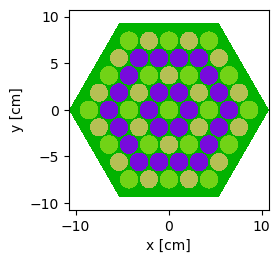

In [16]:
#Empire Core Universe
length = 5
#Length is the number of cells on each side
#It is 1 less than the number of layers out from the central heat pipe

empire_core = openmc.Universe()
empire_core.add_cell(heat_pipe_maker(0,0))

#Cylindrical Cells
def unique_cell_count(x):
    return int((x+1) + (x/2))

for i in range(length):
    cell_count = unique_cell_count(i)

    #Creating Position Arrays w/ Initial Positions
    x_pos = np.zeros(cell_count)
    y_pos = np.zeros(cell_count)

    x0 = i
    y0 = 0

    #Filling Position Arrays
    for j in range(cell_count):
        if j <= i:
            x_pos[j] = x0 - 0.5*j
            y_pos[j] = y0 + (3)**(.5)/2*j
        else:
            x_pos[j] = x_pos[j-1] - 1
            y_pos[j] = y_pos[j-1]

    x_pos = x_pos * monolith_pitch
    y_pos = y_pos * monolith_pitch

    #Adding Cells
    for k in range(cell_count):
        if i%2 != 0:
            four_quad_mod(empire_core,x_pos[k],y_pos[k])
        else:
            if k%2 == 0:
                four_quad_heat_pipe(empire_core,x_pos[k],y_pos[k])
            else:
                four_quad_fuel(empire_core,x_pos[k],y_pos[k])

#Monolith
hexagon = openmc.model.HexagonalPrism(
    edge_length = (length) * monolith_pitch,
    orientation = 'x',
    origin = (0,0),
    boundary_type = 'reflective'
)

monolith = openmc.Cell(
    fill = ss316,
    region = -hexagon
)

empire_core.add_cell(monolith)

#Plotting
scope = 2 * length * monolith_pitch
empire_core.plot(width=(scope,scope),color_by='material')
plt.show()

In [38]:
#Model Settings
model = openmc.Model()
#model.settings.source = openmc.IndependentSource(space=openmc.stats.CylindricalIndependent(radius, 2*np.pi, height))

model.settings.inactive = 200
model.settings.batches = 400
model.settings.particles = 1000

#Running the Model
with openmc.StatePoint(statepoint) as sp:
    mesh_tally_out = sp.get_tally(id=heat.id)

mesh_flux = mesh_tally_out.get_values()
mesh_flux = mesh_flux.reshape(mesh.dimension)

plt.figure()
img = plt.imshow(mesh_flux)
plt.colorbar(img)
plt.xlim(1.25*radius,2.5*radius)
plt.ylim(1.25*radius,2.5*radius)
plt.show()

#mesh = openmc.CylindricalMesh(
#    r_grid = np.linspace(0,radius,50),
#    z_grid = np.linspace(-height/2, height/2, 50),
#    phi_grid = np.linspace(0,2*np.pi,50)
#)
mesh = openmc.RegularMesh()
mesh.lower_left = (-radius, -radius)
mesh.upper_right = (radius, radius)
mesh.dimension = (1000, 1000)

mesh_filter = openmc.MeshFilter(mesh)

heat = openmc.Tally()
heat.scores = ['kappa-fission']
heat.filters = [mesh_filter]
model.tallies = [heat]

model.geometry = openmc.Geometry(circular_universe)
model.materials = openmc.Materials([un, yh2, ss316, cu])

statepoint = model.run(output=True)

In [1]:
#Removes all the output files
!rm *.h5